In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import os

root_dir = '/home/aoezkan/dl_proj/'


In [9]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("cd", root_dir)

/home/aoezkan/dl_proj


In [10]:
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Assuming a single-GPU setup
    device_properties = torch.cuda.get_device_properties(device)

    total_memory = device_properties.total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    print(f"Total GPU Memory: {total_memory / 1e9} GB")
    print(f"Allocated Memory: {allocated_memory / 1e9} GB")
    print(f"Cached Memory: {cached_memory / 1e9} GB")
else:
    print("CUDA is not available.")

print(torch.version.cuda)

Total GPU Memory: 11.71488768 GB
Allocated Memory: 0.0 GB
Cached Memory: 0.0 GB
11.8


In [12]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
# num_classes = CLASS_DICT[dataset]
# eval_batch_size = 1024
checkpoint = 'in21k_imagenet'

# bypass ing
num_classes = 1000
input_size = 64
model_mlp = get_model(architecture=architecture, resolution=input_size, num_classes=num_classes, checkpoint=checkpoint)
model_mlp.linear_out = nn.Linear(1024, 200)

model_full_path = os.path.join("checkpoints", "mlp_b12_wi1024_imagenet_bs128_tinyimagenet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_mlp = torch.nn.DataParallel(model_mlp)
model_mlp.load_state_dict(checkpoint['model'])
model_mlp = model_mlp.to(device)
model_mlp.eval()

Load_state output <All keys matched successfully>


DataParallel(
  (module): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=200, bias=True)
    (blocks): ModuleList(
      (0-11): 12 x BottleneckBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (layernorms): ModuleList(
      (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [13]:
num_classes = 200
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, num_classes)

model_full_path = os.path.join("checkpoints", "ResNet18_TinyImageNet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_resnet = torch.nn.DataParallel(model_resnet)
model_resnet.load_state_dict(checkpoint['model'])
model_resnet = model_resnet.to(device)
model_resnet.eval()

Using cache found in /home/aoezkan/.cache/torch/hub/pytorch_vision_v0.10.0
/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
timm_path = os.path.join(root_dir, "../pytorch-image-models/")
ipython.run_line_magic("cd", timm_path)
import timm
ipython.run_line_magic("cd", root_dir)

/home/aoezkan/pytorch-image-models
/home/aoezkan/dl_proj


In [15]:
model_vit = timm.create_model("vit_tiny_patch16_224", pretrained=True)
model_vit.head = nn.Linear(model_vit.head.in_features, 200) # tinyimagnet


model_full_path = os.path.join("checkpoints", "vit_tiny_patch16_224_unfrozen_tinyimagenet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_vit = torch.nn.DataParallel(model_vit)
model_vit.load_state_dict(checkpoint['model'])
model_vit = model_vit.to(device)
model_vit.eval()

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')


In [18]:
import urllib
import ast

# The URL which has stored the categories of ImageNet
url_class = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

# Load the classes and store them as a list
labels = []
for line in urllib.request.urlopen(url_class):
  txt = line.decode('utf-8')
  # Clean the string
  label = ''.join([i for i in txt if not i.isdigit() and i != ':' and i != ','])
  labels.append(label.strip())

print('We have', len(labels), 'classes')

# That's the Toucan label
true_label = 1
print(str(true_label) + '-th label is', labels[true_label])

We have 1000 classes
1-th label is 'goldfish Carassius auratus'


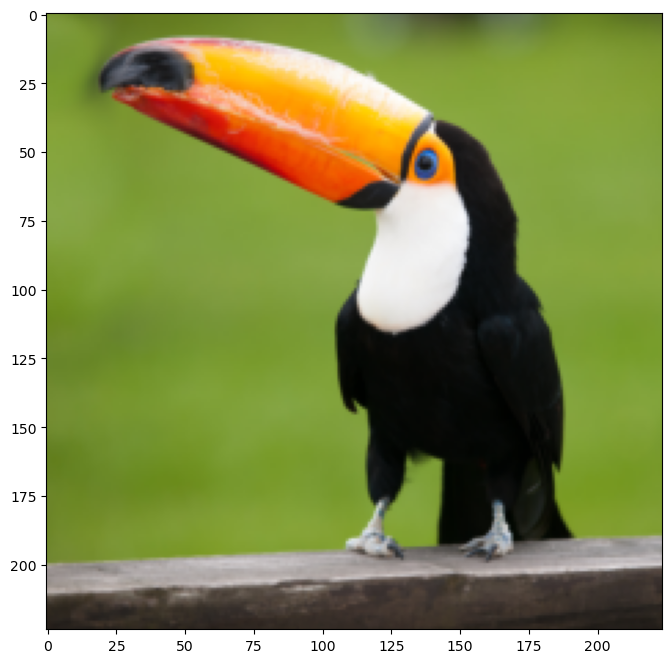

In [18]:
from PIL import Image
import requests
from torchvision import transforms
import matplotlib.pyplot as plt

# Download example image from website
url = 'https://user-images.githubusercontent.com/38691167/145074001-b81f53df-2075-4683-ab9b-c02dd53794a7.jpg'
img = Image.open(requests.get(url, stream=True).raw)

# Resize the image to ImageNet size
preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
])

x = preprocess(img)[None,:,:,:]
# Plot the image
plt.rcParams['figure.figsize'] = [8, 8]
plt.imshow(x[0].numpy().transpose(1,2,0))

In [5]:
# The mean and std of ImageNet samples
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

# Define a normalization function
def normalize(x):
  return (x - mean[None,:,None,None]) / std[None,:,None,None]

# Normalize the image (think of 'normalize' as a map between image space and network space)
x_norm = normalize(x)
# Get the logits of the model
logits = model(x_norm)
# Convert it to a 'hard' prediction
pred = torch.argmax(logits)
print('The image is a ', labels[pred])

The image is a  'toucan'


In [58]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

In [59]:
class ClassMaxim(nn.Module):
    def __init__(self):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(1, 3, 224, 224))  
        self.clone = self.x_c.clone()

In [62]:
from torchvision.transforms.functional import gaussian_blur
from IPython.display import display, clear_output
clsmax = ClassMaxim()
lamb = 0.2
lr = 128

sigma = 1
steps = 3
clss = car_id_list[2]

<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


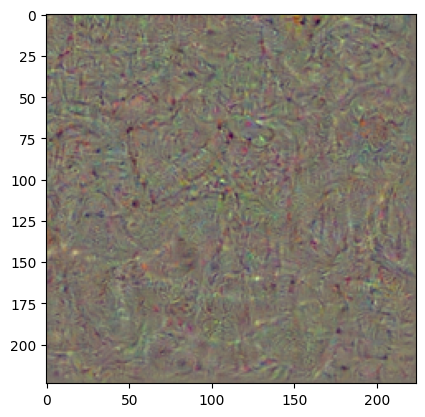

In [63]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)

plt.figure()
for i in range(40):
    lr-=2
    if lr <= 16:
        lr = 16
    plt.imshow((clsmax.x_c[0]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()
    for step in range(20):
        xx = clsmax.x_c[0]
        preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
        preds = preds.squeeze(0)

        loss = (preds[clss] - lamb*(torch.norm(clsmax.x_c[0],p=2)))
        (loss).backward()
        
        grad = clsmax.x_c.grad / (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
        clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent
        with torch.no_grad():
            min_value = torch.min(clsmax.x_c)
            max_value = torch.max(clsmax.x_c)
            normalized_tensor = (clsmax.x_c - min_value) / (max_value - min_value)
            blurred_tensor = normalized_tensor
            if step % 4 == 0:
                blurred_tensor = gaussian_blur(normalized_tensor, steps, sigma)
            clipped_tensor = blurred_tensor
            norms = torch.norm(blurred_tensor, dim=1, p=2)
            below_threshold = norms < 0.001
            blurred_tensor[:, :, below_threshold.squeeze(0)] = 0

            #threshold = 0.00001
            #clipped_tensor = torch.where(blurred_tensor < threshold, torch.zeros_like(blurred_tensor), blurred_tensor)
            clsmax.x_c = nn.Parameter(clipped_tensor  * (max_value - min_value) + min_value)
    #sigma *= 0.99
    if(i < 39):
        clear_output(wait=True)
        display(plt.gcf())


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
from PytorchRevelio import PytorchRevelio
from utilities_PytorchRevelio import imagenet_labels

In [ ]:
import torchvision.models as models
# model = models.resnet18(pretrained=True)
#model = torchvision.models.alexnet(pretrained=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

# WRAPPERS

In [106]:
class MLP_Wrapper(nn.Module):
    def __init__(self, model, input_size):
        super(MLP_Wrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = x.flatten(1)
        x = self.model(x)
        return x

In [128]:
input_size = 64

model_mlp_wrap = MLP_Wrapper(model_mlp, input_size)
model_mlp_wrap = model_mlp_wrap.to(device)
model_mlp_wrap.eval()

MLP_Wrapper(
  (model): DataParallel(
    (module): BottleneckMLP(
      (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
      (linear_out): Linear(in_features=1024, out_features=200, bias=True)
      (blocks): ModuleList(
        (0-11): 12 x BottleneckBlock(
          (block): Sequential(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=4096, out_features=1024, bias=True)
          )
        )
      )
      (layernorms): ModuleList(
        (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (resize): Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
)

In [129]:
model = model_mlp_wrap
# model = model_resnet
# model = model_resnet

In [130]:
model_mlp_layers = ['model.module.linear_in', 'model.module.linear_out']

In [131]:
for key, value in PytorchRevelio.layers_name_type(model):
        print('+' * 10)
        print(key)
        print('-' * 10)
        print(value)

++++++++++

----------
MLP_Wrapper(
  (model): DataParallel(
    (module): BottleneckMLP(
      (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
      (linear_out): Linear(in_features=1024, out_features=200, bias=True)
      (blocks): ModuleList(
        (0-11): 12 x BottleneckBlock(
          (block): Sequential(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=4096, out_features=1024, bias=True)
          )
        )
      )
      (layernorms): ModuleList(
        (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (resize): Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
)
++++++++++
model
----------
DataParallel(
  (module): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=200, bias=True)
    (blocks): ModuleLis

In [132]:
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

input_size = 64

img_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=transform_mean, std=transform_std),
    ])

In [133]:
class_names = ['goldfish, Carassius auratus', 'European fire salamander, Salamandra salamandra', 'bullfrog, Rana catesbeiana', 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'American alligator, Alligator mississipiensis', 'boa constrictor, Constrictor constrictor', 'trilobite', 'scorpion', 'black widow, Latrodectus mactans', 'tarantula', 'centipede', 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'jellyfish', 'brain coral', 'snail', 'sea slug, nudibranch', 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'black stork, Ciconia nigra', 'king penguin, Aptenodytes patagonica', 'albatross, mollymawk', 'dugong, Dugong dugon', 'Yorkshire terrier', 'golden retriever', 'Labrador retriever', 'German shepherd, German shepherd dog, German police dog, alsatian', 'standard poodle', 'tabby, tabby cat', 'Persian cat', 'Egyptian cat', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'brown bear, bruin, Ursus arctos', 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'grasshopper, hopper', 'walking stick, walkingstick, stick insect', 'cockroach, roach', 'mantis, mantid', "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'sulphur butterfly, sulfur butterfly', 'sea cucumber, holothurian', 'guinea pig, Cavia cobaya', 'hog, pig, grunter, squealer, Sus scrofa', 'ox', 'bison', 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'gazelle', 'Arabian camel, dromedary, Camelus dromedarius', 'orangutan, orang, orangutang, Pongo pygmaeus', 'chimpanzee, chimp, Pan troglodytes', 'baboon', 'African elephant, Loxodonta africana', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'abacus', "academic gown, academic robe, judge's robe", 'altar', 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'bannister, banister, balustrade, balusters, handrail', 'barbershop', 'barn', 'barrel, cask', 'basketball', 'bathtub, bathing tub, bath, tub', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'beacon, lighthouse, beacon light, pharos', 'beaker', 'beer bottle', 'bikini, two-piece', 'binoculars, field glasses, opera glasses', 'birdhouse', 'bow tie, bow-tie, bowtie', 'brass, memorial tablet, plaque', 'bucket, pail', 'bullet train, bullet', 'butcher shop, meat market', 'candle, taper, wax light', 'cannon', 'cardigan', 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM', 'CD player', 'chest', 'Christmas stocking', 'cliff dwelling', 'computer keyboard, keypad', 'confectionery, confectionary, candy store', 'convertible', 'crane', 'dam, dike, dyke', 'desk', 'dining table, board', 'dumbbell', 'flagpole, flagstaff', 'fly', 'fountain', 'freight car', 'frying pan, frypan, skillet', 'fur coat', 'gasmask, respirator, gas helmet', 'go-kart', 'gondola', 'hourglass', 'iPod', 'jinrikisha, ricksha, rickshaw', 'kimono', 'lampshade, lamp shade', 'lawn mower, mower', 'lifeboat', 'limousine, limo', 'magnetic compass', 'maypole', 'military uniform', 'miniskirt, mini', 'moving van', 'neck brace', 'obelisk', 'oboe, hautboy, hautbois', 'organ, pipe organ', 'parking meter', 'pay-phone, pay-station', 'picket fence, paling', 'pill bottle', "plunger, plumber's helper", 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 'poncho', 'pop bottle, soda bottle', "potter's wheel", 'projectile, missile', 'punching bag, punch bag, punching ball, punchball', 'refrigerator, icebox', 'remote control, remote', 'rocking chair, rocker', 'rugby ball', 'sandal', 'school bus', 'scoreboard', 'sewing machine', 'snorkel', 'sock', 'sombrero', 'space heater', "spider web, spider's web", 'sports car, sport car', 'steel arch bridge', 'stopwatch, stop watch', 'sunglasses, dark glasses, shades', 'suspension bridge', 'swimming trunks, bathing trunks', 'syringe', 'teapot', 'teddy, teddy bear', 'thatch, thatched roof', 'torch', 'tractor', 'triumphal arch', 'trolleybus, trolley coach, trackless trolley', 'turnstile', 'umbrella', 'vestment', 'viaduct', 'volleyball', 'water jug', 'water tower', 'wok', 'wooden spoon', 'comic book', 'reel', 'guacamole', 'ice cream, icecream', 'ice lolly, lolly, lollipop, popsicle', 'goose', 'drumstick', 'plate', 'pretzel', 'mashed potato', 'cauliflower', 'bell pepper', 'lemon', 'banana', 'pomegranate', 'meat loaf, meatloaf', 'pizza, pizza pie', 'potpie', 'espresso', 'bee', 'apron', 'pole', 'Chihuahua', 'alp', 'cliff, drop, drop-off', 'coral reef', 'lakeside, lakeshore', 'seashore, coast, seacoast, sea-coast', 'acorn', 'broom', 'mushroom', 'nail', 'chain', 'slug', 'orange']

In [134]:
car_id_list = [] 
dog_id_list = [] 
orange_id_list = []

for i, x in enumerate(class_names):
    if 'car' in x:
        car_id_list.append(i)
    elif 'dog' in x:
        dog_id_list.append(i)
    elif 'orange' in x:
        orange_id_list.append(i)

In [135]:
print(car_id_list)
print([class_names[id] for id in car_id_list])
print(dog_id_list)
print(orange_id_list)

[64, 78, 95, 142]
['beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'cardigan', 'freight car', 'sports car, sport car']
[25]
[199]


In [136]:
import os
# for different convolutional filter and neuron in fully connected layer
# show representation
first_layer_name = model_mlp_layers[0] # 'module.conv1'
last_layer_name = model_mlp_layers[1]  # 'module.fc'
#for layer_name in model.named_modules():

layer_name = last_layer_name #layer_name[0]
# select convolutional and fully connected layers for visualization
layer = PytorchRevelio.return_module_by_name(network=model, module_name=layer_name)
if isinstance(layer, nn.Conv2d):
    filter_neuron_num = layer.out_channels
    layer_type = 'Conv2d'
    num_iter = 150
    lr = 1
elif isinstance(layer, nn.Linear):
    filter_neuron_num = layer.out_features
    layer_type = 'Linear'
    num_iter = 500
    lr = 1
else:
    pass
    #continue


save_dir = 'revelio/visualization_images'
os.makedirs(save_dir, exist_ok=True)

filter_neuron_index = car_id_list[2]

# for each selected filter or neuron, calculate representation
plt.figure()

in_img_size=(64, 64, 3) # tinyimgnet
# in_img_size=(224, 224, 3) # imagenet

img = PytorchRevelio.activation_maximization(network=model, img_transformer=img_transformer,
                                             in_img_size=in_img_size,
                                             first_layer_name=first_layer_name, layer_name=layer_name,
                                             filter_or_neuron_index=filter_neuron_index, num_iter=num_iter,
                                             lr=lr, device=device)

# to cpu and normalize for illustration purpose
img = PytorchRevelio.tensor_outputs_to_image(img)
plt.figure()
plt.imshow(img)
plt.title("{} - {}".format(layer_name, filter_neuron_index))
plt.axis('off')
# Save the image
save_path = os.path.join(save_dir, "{}_{}.png".format(layer_name, filter_neuron_index))
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
plt.close()

/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<Figure size 640x480 with 0 Axes>

In [34]:
to_tensor = transforms.ToTensor()
tensor_image = to_tensor(img).clone()
tt = normalize(tensor_image)
# Get the logits of the model
logits_tt = model(tt)
# Convert it to a 'hard' prediction
pred_tt = torch.argmax(logits_tt)
print('The image is a ', labels[pred_tt])

NameError: name 'normalize' is not defined